<a href="https://colab.research.google.com/github/ramonfv/iniciacao-cientifica-BCI/blob/main/Script_Iniciacao_Ramon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor:
Ramon Fernandes Viana

#Implementação de um sistema BCI-SSVEP
---



Este script faz parte da implementação das etapas de construção de uma BCI (Brain Computer Interface).

Este trabalho contém as seguintes partes: Entrada de dados, Pré-Processamento, Estração de Características, Seleção de Características e Classificação



A base de dados utilizada neste trabalho pode ser acessada pelo link:
http://bci.med.tsinghua.edu.cn/download.html

In [1]:
#Bibliotecas científicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sp
import scipy.io as sio
from scipy import signal
from scipy.fft import fft
import math 
import scipy.fftpack
from numpy import array
from scipy.io import loadmat
from itertools import combinations 
import requests

#Biblioteca de aprendizado de máquina
from sklearn.model_selection import train_test_split
from tensorflow import keras as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from sklearn.cross_decomposition import CCA
from tensorflow.keras.optimizers import *


##Importando a base de dados e selecionando os indivíduos

In [2]:
#Biblioteca para acessar o Google Drive
from google.colab import drive

#Endereço da base de dados no Google Drive
path_database = '/content/gdrive/MyDrive/IC_Ramon/S34.mat'
# O sinal filtrado (CAR) para o indivíduo 34 está em:
# /content/gdrive/MyDrive/Colab Notebooks/Iniciação/Sinais_Filtrados/CAR/filtragem_CAR.mat

# import os 
# path_database = '/content/gdrive/MyDrive/IC_Ramon/'
# os.chdir(path_database)
# !ls

#Autoriza a leitura do Google Drive
drive.mount('/content/gdrive')

# O indivíduo testado -- 34          
mat = sio.loadmat(path_database, verify_compressed_data_integrity=False) 
intDados = np.array(mat['data'])
intDados = intDados[:,125:1375,:,:]

# mat = sp.loadmat('/content/drive/MyDrive/IC_Ramon/S34.mat')
# eegSignal = np.array(mat['data'])
# eegSignal = eegSignal[:,125:1375,:,:]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Função para baixar todos os indivíduos presentes na base

In [3]:
# import requests

# def get_baixa_dados(sujeito: str):
#   url = f'http://bci.med.tsinghua.edu.cn/download.html/{sujeito}.zip'
#   r = requests.get(url, allow_redirects=True)

#   with open(f'{sujeito}.zip', 'wb') as zf:
#         zf.write(requests.get(url).content)

# get_baixa_dados('S1.mat')        

#Parâmentros e variáveis auxiliares

In [4]:
# Parâmetros de entrada
# conforme definido no artigo, o sinal coletado tem duração de 6s no entanto os 0,5s iniciais e finais são desconsiderados
# intDados = data[:,125:1375,:,:]
rows,cols,freqs,trials = intDados.shape
freqList = [0, 2, 4, 7]
freqReal = np.array([8, 10, 12, 15])
numFreq = len(freqList)
# Frequência de Amostragem
Fs = 250
resEsp = Fs/1250
freq = np.arange(1250)*(resEsp)
# vetor de tempo
time = np.arange(1250)*1/Fs

#Número de seções
numSecoes = 6

#Duração de cada sinal em segundos
tTotal=5

#Tamanho do janelamento
T=1

# ordem do filtro
ordemFiltro = 10

#Número de canais
#Para 64 utilizar a variável rows
numEletrodos = 16

# combCanais= list(combinations([46,47,48,54,55,56,60,61,62], 2)) 
combCanais= list(combinations([18, 26, 27, 28, 37, 46,47,48, 52, 54,55,56, 58 ,60,61,62], 2)) 
# NOVOS CANAIS: 18, 26, 27, 28, 37, 52, 58
#janelas 0:250, 125:375, 250:500, 375:625, 

# taxa = Fs\2
# janela*taxa:janenas*taxa+Fs

#número de janelas por sinal
# numJanelas = int(tTotal/T)
numJanelas = 8

#Inicialização da matriz de atributos
H_FFT = np.zeros((numJanelas*len(freqReal)*numSecoes,len(freqReal)*len(combCanais)))
print(H_FFT.shape)

(192, 480)


In [5]:
taxa = int(Fs*0.6)
taxa

150

In [6]:
len(combCanais)

120

#Função para obter a matriz C


Os sinais observados em cada eletrodo idealmente podem ser escritos como uma soma de sinais senoidais, oscilando em uma determinada frequência

In [7]:
def matrizC(freqReal, numEntrada, ordemFiltro):
  # o parâmetro numEntrada é definido na função filtro MVDR
  COS = []
  SEN = []
  for f in freqReal:
    COSpos = []
    SENpos = []
    for i in range(0, numEntrada):
      # encontrando o vetor de cossenos que compõe a matriz C, este que varia de
      # acordo com a ordem escolhida para o filtro
      cos_Pos = np.zeros((numEntrada*ordemFiltro))
      # cos_pos[i*ordemFiltro:(i*ordemFiltro) + ordemFiltro] = np.cos(2*np.pi*m*f/250)
      cos_Pos[i*ordemFiltro:(i*ordemFiltro) + ordemFiltro] = np.cos(2*np.pi*ordemFiltro*f/250)
      COSpos.append(cos_Pos)
      # encontrando o vetor de senos que compõe a matriz C
      sen_Pos = np.zeros((numEntrada*ordemFiltro))
      sen_Pos[i*ordemFiltro:(i*ordemFiltro) + ordemFiltro] = np.sin(2*np.pi*ordemFiltro*f/250)
      SENpos.append(sen_Pos)

    # incremento do vetor principal
    COS.append(COSpos)
    SEN.append(SENpos)

  COS = np.reshape(COS, (numEntrada*len(freqReal), numEntrada*ordemFiltro))
  SEN = np.reshape(SEN, (numEntrada*len(freqReal), numEntrada*ordemFiltro))
  
  # Retorna a matriz C descrina na seção ...
  C = np.concatenate((np.transpose(COS), np.transpose(SEN)), axis = -1)   
  return C

# Função que filtra o sinal com a técnica MVDR

In [8]:
def filtroMVDR(x1, x2, ordemFiltro, f, Fs):
  nFreq = len(f) 
  # produzindo os sinais a partir do número de eletrodos e amostras 
  sinais = np.concatenate((np.expand_dims(x1, axis = 0),
                           np.expand_dims(x2, axis = 0)))
  
  numEntrada = sinais.shape[0]

  C = matrizC(freqReal, numEntrada, ordemFiltro)
  # vetor que garante a coerência de UNS para o cosseno e ZEROS para o seno
  g = np.concatenate((np.ones(numEntrada*len(f)), np.zeros(numEntrada*len(f))))

  sinais = np.concatenate((sinais, sinais[:, -ordemFiltro:]), axis = -1)
  X = []

  for i in range(0, sinais.shape[-1]-ordemFiltro):
    Xt = sinais[:, i:ordemFiltro+i]
    # np.fliplr inverte a ordem dos elementos ao longo do eixo 1
    Xt = np.fliplr(Xt)
    # flatten retona uma cópia da matriz/vetor em outra dimensão
    X.append(Xt.flatten())
 # entradas combinadas    
  X = np.transpose(np.array(X))

# Correlação
  R = X @ np.transpose(X) 
  Rinv = np.linalg.pinv(R)  
  # coeficientes do filtro
  W = Rinv @ C @ np.linalg.pinv((np.transpose(C) @ Rinv @ C)) @ g

  # saída correspondente a filtragem dos eletrodos combinados
  yFiltrado = W @ X

  return yFiltrado


##Encontrando as localizações de cada frequência

In [9]:
freqNew = np.arange(0,250,1)
freqNew.shape
def frequencias(freqNew,numFreq, freqReal):
  binFreq = [0 for i in range(numFreq)]
  for localizacao in range(numFreq):  
    binFreq[localizacao] = np.where(freqNew == freqReal[localizacao]) 
  return binFreq  
posicoesFreq = frequencias(freqNew,numFreq, freqReal)
posicoesFreq = np.asarray(posicoesFreq)
for i in range(numFreq):
  posicoesFreq[i] = posicoesFreq[i].item() 
posicoesFreq  

array([[[ 8]],

       [[10]],

       [[12]],

       [[15]]])

##Extração de Características - Análise com a FFT

In [10]:
intDados.shape

(64, 1250, 40, 6)

In [11]:
 saida_filtro = np.zeros((Fs,len(combCanais)))
 saida_filtro.shape

(250, 120)

In [12]:
# matriz H - Extração com Método da FFT
# H_FFT = np.zeros((janelas*numFreq*trials,numFreq*rows))
H_AUX = np.zeros(numFreq)
# número de janelas do sinal
numJanelas                
for freqs_sinal in range(0,numFreq):
  for trial in range(0,trials):
    for jan in range(numJanelas):
      taxa = 150
      # janela_inicio = jan*250*T
      # janela_fim = janela_inicio+T*250
      janela_inicio = jan*taxa
      janela_fim = jan*taxa+Fs
      # taxa = Fs\2
      # janela*taxa:janenas*taxa+Fs
      # janela = np.arange(janela_inicio,janela_fim)
      for canais in range (len(combCanais)):
        tupleX = combCanais[canais]
        x1 = tupleX[0]
        x2 = tupleX[1]
        # FFT =  np.abs(fft(int_dados[canais,janela,freqList[freqs_sinal],trial]))
        yFiltrado = filtroMVDR(intDados[x1,janela_inicio:janela_fim ,freqList[freqs_sinal],trial],
                               intDados[x2,janela_inicio:janela_fim ,freqList[freqs_sinal],trial],
                               10,
                               freqReal,
                               250)
        # saida_filtro[:,canais] =  yFiltrado
        yFFT = np.abs(scipy.fftpack.fft(yFiltrado))

        for indices in range(numFreq):
          H_AUX[indices] = yFFT[T*freqReal[indices]]
        H_FFT[trials*numJanelas*freqs_sinal+jan+(numJanelas *(trial)), 
                                  canais*numFreq:((canais+1)*numFreq)] = H_AUX
    

## Seleção de Atributos através do método de correlação de Pearson

In [13]:
# SELECOA DE ATRIBUTOS COM PEARSON
#*************************************************
# A = np.array(H_FFT);  #matriz de características
# uns_pos = np.ones((numJanelas *trials,rows))
# uns_neg = -np.ones((numJanelas *trials,rows))

# Vet_1 = np.array(np.vstack((uns_pos,uns_neg,uns_pos,uns_neg)))
# Vet_2 = np.array(np.vstack((uns_neg,uns_pos,uns_neg,uns_pos)))

# B = np.array(np.hstack((Vet_1,Vet_2,Vet_1,Vet_2)));
# B.shape

##Calculos dos eletrodos mais significativos para as frequências desejadas

In [14]:
# Vetor_R =  np.zeros((A.shape[1],B.shape[1]))

# for freq in range (B.shape[1]):
#   for ch in range (A.shape[1]):
#     print(freq,ch)
#     print(A[:,ch], B[:,freq])
#     R = np.corrcoef(A[:,ch],B[:,freq])
#     Vetor_R[ch,freq] = np.abs(R[1,0])

# print(Vetor_R.shape)
# indices_canais = np.argsort(Vetor_R, axis=0)[::-1]
# print(indices_canais.shape)

In [15]:
H_FFT.shape

(192, 480)

# Classificador Linear

## Matriz de rótulos

In [16]:
# numero de amostras para a criação da matriz de rótulos
numberSamples = int(len(H_FFT)/4)

#Inicializa a matriz de rótulos
trainingMatrix = np.zeros((numberSamples*numFreq,len(combCanais)*numFreq))

#Cria matriz de rótulos inicializa com -1
R = np.full((len(trainingMatrix), numFreq), -1)

#Adiciona +1 nas posições corretas
for frequency in range(numFreq):
  for position in range(numberSamples):
    R[(numberSamples*frequency)+position, frequency] = 1

print(R.shape)

uns = np.ones((len(H_FFT),1))
# matriz atributos
H = np.array(np.hstack((H_FFT,uns)))
print(H.shape)

  

(192, 4)
(192, 481)


Classificação

#Classificador Linear


In [17]:
from sklearn.model_selection import train_test_split
from sklearn import svm

#Considerando as matrizes com os dados em H e a matriz de rótulos R - equivalente ao código inicial do Matlab
#Particionar os dados usando 20% para validacao
Ht, Hv, Rt, Rv = train_test_split(H, R, test_size = 0.20)

#SVM - treinando
# SEED = 50
# np.random.seed(SEED)
Y = svm.SVC(kernel='linear').fit(Ht, Rt[:,0]).predict(Hv)
for frequency in range(1,numFreq):
  modelo= svm.SVC(kernel='linear').fit(Ht, Rt[:,frequency])
  Y_Aux = modelo.predict(Hv)
  Y = np.vstack([Y,Y_Aux])

Y = Y.transpose()
index = np.argmax(Y, axis=1)
index2 = np.argmax(Rv, axis=1)

# contando os acertos
cont_corretos = [0 for i in range(numFreq)]
num_index = [0 for i in range(numFreq)]
acuracia =  [0 for i in range(numFreq)]

for i in range(len(Rv)):
    #if((Y[i,:]==Rv[i,:])):
  if (index[i] == 0 and index2[i] == 0):
    cont_corretos[0] = cont_corretos[0] + 1   
  elif (index[i] == 1 and index2[i] == 1):   
    cont_corretos[1] = cont_corretos[1] + 1
  elif (index[i] == 2 and index2[i] == 2):
    cont_corretos[2] = cont_corretos[2] + 1
  elif (index[i] == 3 and index2[i] == 3):
    cont_corretos[3] = cont_corretos[3] + 1    

# plotando a taxa de acerto final para cada frequência
print("Taxa de acerto por frequência:\n")
for soma in range(numFreq):
  num_index[soma] = sum(index == soma)        
  acuracia[soma] =  (cont_corretos[soma]/num_index[soma])*100
  print('Frequência {label} ({numfreq}Hz): {acerto}%'.format(label = soma, numfreq = freqReal[soma], acerto = acuracia[soma]))

print("\nDesempenho total da BCI:\n")
desem_total = (sum(acuracia)/numFreq)
print('{desempenho}%'.format(desempenho =desem_total))

Taxa de acerto por frequência:

Frequência 0 (8Hz): 55.00000000000001%
Frequência 1 (10Hz): 100.0%
Frequência 2 (12Hz): 57.14285714285714%
Frequência 3 (15Hz): 80.0%

Desempenho total da BCI:

73.03571428571428%


Validação do Classificador Linear

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [19]:
modelot= svm.SVC(kernel='linear')
cv = KFold(n_splits=5, shuffle= True)
for frequency in range(numFreq):
  results = cross_validate(modelot,H_FFT, R[:,frequency], cv = cv, return_train_score=False)
  mean = results['test_score'].mean()
  desvioPadrao = results['test_score'].std()
  print('Accuracy médio freq ({numfreq}Hz): {acerto}%' .format(numfreq = freqReal[frequency], acerto = mean*100))
  print('Accuracy intervalo: [%.2f, %.2f]' %((mean - 2*desvioPadrao)*100, (mean + 2*desvioPadrao)*100))

Accuracy médio freq (8Hz): 88.56950067476383%
Accuracy intervalo: [82.53, 94.61]
Accuracy médio freq (10Hz): 89.06882591093117%
Accuracy intervalo: [85.24, 92.90]
Accuracy médio freq (12Hz): 89.5681511470985%
Accuracy intervalo: [83.72, 95.41]
Accuracy médio freq (15Hz): 84.87179487179488%
Accuracy intervalo: [80.64, 89.10]


#Rede Neural Convulocional (CNN)

In [20]:
# alterando a matriz de rótulos (no lugar de -1 vai passar a ser 1)
R_CNN = np.where(R == 1, R, 0)
R_CNN.shape

(192, 4)

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()
scaler.fit(H_FFT)
scaled = scaler.transform(H_FFT)
scaled.shape

(192, 480)

In [23]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(H_FFT)
# scaled.shape

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(scaled, R_CNN, test_size = 0.25)
xtrain = np.reshape(xtrain, (144,480,1))
ytrain = np.reshape(ytrain, (144,4))
xtest = np.reshape(xtest, (48,480,1))
ytest = np.reshape(ytest, (48,4))
# xtrain = np.reshape(xtrain, (90,144,1))
# ytrain = np.reshape(ytrain, (90,4))
# xtest = np.reshape(xtest, (30,144,1))
# ytest = np.reshape(ytest, (30,4))
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print( ytest.shape)

(144, 480, 1)
(48, 480, 1)
(144, 4)
(48, 4)


In [25]:
n_features, reshape_input, n_outputs = xtrain.shape[1], xtrain.shape[2], R_CNN.shape[1]
print(n_features)
print(reshape_input)
print(n_outputs)

480
1
4


In [26]:
# from tensorflow.keras.utils import to_categorical

In [27]:
# o input shape assume a mesma dimensão da matriz de atributos
input_shape = (n_features,1)
tamFiltro = 110
# 48 tam ideial
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
tamKernel = 10
# 10 tam ideial
numItens = 4


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization

# selu, elu, sigmoid, softplus, softsign,

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 471, 110)          1210      
                                                                 
 conv1d_1 (Conv1D)           (None, 462, 110)          121110    
                                                                 
 batch_normalization (BatchN  (None, 462, 110)         1848      
 ormalization)                                                   
                                                                 
 average_pooling1d (AverageP  (None, 231, 110)         0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 231, 110)          0         
                                                                 
 flatten (Flatten)           (None, 25410)             0

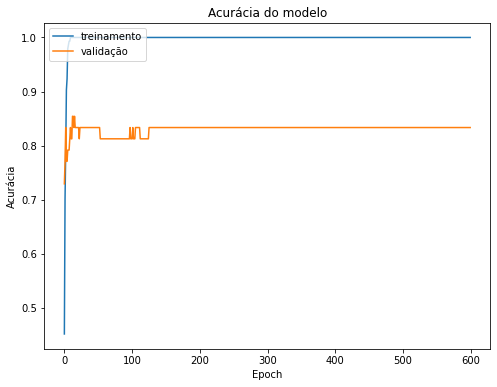

In [29]:
# topologia MELHOR RESULTADO 9 CANAIS
model = Sequential()
model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh', input_shape=(input_shape)))
model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='relu'))
# model.add(MaxPooling1D())
# model.add(AveragePooling1D())
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))

# model.add(AveragePooling1D())
model.add(BatchNormalization(axis=1))
model.add(AveragePooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.3))
# model.add(Dropout(0.3))
# model.add(MaxPooling1D(pool_size=3, padding='same')),    
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# # model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))

# model.add(BatchNormalization(axis=1))
# model.add(AveragePooling1D(pool_size=2, padding='same'))
# model.add(Dropout(0.45))
#       # MaxPooling1D(), 
 # taxa de aprendizagem
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()
# model.add(Flatten())
model.compile(optimizer=SGD(learning_rate = 0.07),              
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
# Accuracy
# categorical_accuracy'
# categorical_crossentropy
history = model.fit(xtrain, ytrain, epochs= 600, verbose = 0,validation_data=(xtest, ytest))
plt.figure(figsize=(8, 6))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['treinamento', 'validação'], loc='upper left')
plt.show()

In [30]:
# topologia MELHOR RESULTADO 9 CANAIS
# model = Sequential()
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh', input_shape=(input_shape)))
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# # model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='relu'))
# # model.add(MaxPooling1D())
# # model.add(AveragePooling1D())
# # model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# # model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# # model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))

# # model.add(AveragePooling1D())
# model.add(BatchNormalization(axis=1))
# model.add(AveragePooling1D(pool_size=2, padding='same'))
# model.add(Dropout(0.3))
# # model.add(Dropout(0.3))
# # model.add(MaxPooling1D(pool_size=3, padding='same')),    
# # model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# # # model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))

# # model.add(BatchNormalization(axis=1))
# # model.add(AveragePooling1D(pool_size=2, padding='same'))
# # model.add(Dropout(0.45))
# #       # MaxPooling1D(), 
#  # taxa de aprendizagem
# # model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(1000, activation='tanh'))
# model.add(Dense(100, activation='tanh'))
# model.add(Dropout(0.1))
# model.add(Dense(n_outputs, activation='softmax'))
# model.summary()
# # model.add(Flatten())
# model.compile(optimizer=SGD(learning_rate = 0.05),              
#               loss='categorical_crossentropy',
#               metrics=['categorical_accuracy'])
# # Accuracy
# # categorical_accuracy'
# # categorical_crossentropy
# history = model.fit(xtrain, ytrain, epochs= 600, verbose = 0,validation_data=(xtest, ytest))
# plt.figure(figsize=(8, 6))
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('Acurácia do modelo')
# plt.ylabel('Acurácia')
# plt.xlabel('Epoch')
# plt.legend(['treinamento', 'validação'], loc='upper left')
# plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 471, 110)          1210      
                                                                 
 conv1d_3 (Conv1D)           (None, 462, 110)          121110    
                                                                 
 batch_normalization_1 (Batc  (None, 462, 110)         1848      
 hNormalization)                                                 
                                                                 
 average_pooling1d_1 (Averag  (None, 462, 110)         0         
 ePooling1D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, 462, 110)          0         
                                                                 
 flatten_1 (Flatten)         (None, 50820)            

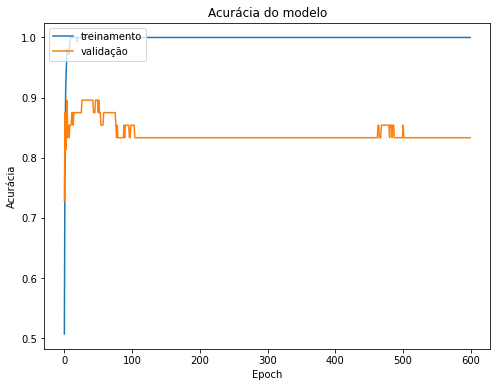

In [31]:
# topologia
model = Sequential()
model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh', input_shape=(input_shape)))
model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='relu'))
# model.add(MaxPooling1D())
# model.add(AveragePooling1D())
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))

# model.add(AveragePooling1D())
model.add(BatchNormalization(axis=1))
model.add(AveragePooling1D(pool_size=1, padding='same'))
model.add(Dropout(0.3))
# model.add(Dropout(0.3))
# model.add(MaxPooling1D(pool_size=3, padding='same')),    
# model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
# # model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))

# model.add(BatchNormalization(axis=1))
# model.add(AveragePooling1D(pool_size=2, padding='same'))
# model.add(Dropout(0.45))
#       # MaxPooling1D(), 
 # taxa de aprendizagem
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()
# model.add(Flatten())
model.compile(optimizer=SGD(learning_rate = 0.009),              
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
# Accuracy
# categorical_accuracy'
# categorical_crossentropy
history = model.fit(xtrain, ytrain, epochs= 600, verbose = 0,validation_data=(xtest, ytest))
plt.figure(figsize=(8, 6))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['treinamento', 'validação'], loc='upper left')
plt.show()

In [32]:
model.evaluate(xtest, ytest)

2/2 [==============================] - 0s 104ms/step - loss: 0.3271 - categorical_accuracy: 0.8333


[0.3271436393260956, 0.8333333134651184]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 471, 110)          1210      
                                                                 
 conv1d_5 (Conv1D)           (None, 462, 110)          121110    
                                                                 
 batch_normalization_2 (Batc  (None, 462, 110)         1848      
 hNormalization)                                                 
                                                                 
 average_pooling1d_2 (Averag  (None, 231, 110)         0         
 ePooling1D)                                                     
                                                                 
 dropout_4 (Dropout)         (None, 231, 110)          0         
                                                                 
 flatten_2 (Flatten)         (None, 25410)            

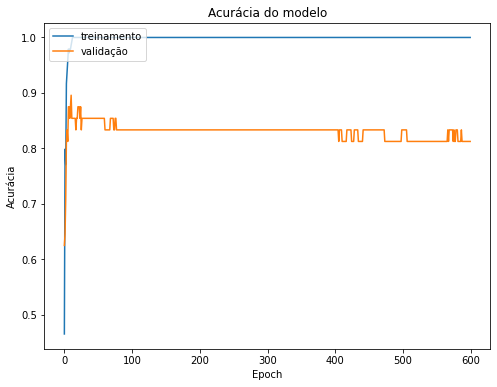

In [33]:
# topologia
model = Sequential()
model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh', input_shape=(input_shape)))
model.add(Conv1D(filters=tamFiltro, kernel_size=tamKernel, activation='tanh'))
model.add(BatchNormalization(axis=1))
model.add(AveragePooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()
model.compile(optimizer=SGD(learning_rate = 0.015),              
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
# Accuracy
# categorical_accuracy'
# categorical_crossentropy
history = model.fit(xtrain, ytrain, epochs= 600, verbose = 0,validation_data=(xtest, ytest))
plt.figure(figsize=(8, 6))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['treinamento', 'validação'], loc='upper left')
plt.show()

Accuracy metrics

* Accuracy class
* BinaryAccuracy class
* CategoricalAccuracy class
* SparseCategoricalAccuracy class
* TopKCategoricalAccuracy class
* SparseTopKCategoricalAccuracy class

Probabilistic metrics

* BinaryCrossentropy class
* CategoricalCrossentropy class
* SparseCategoricalCrossentropy class
* KLDivergence class
* Poisson class

Available losses

* BinaryCrossentropy class
* CategoricalCrossentropy class
* SparseCategoricalCrossentropy class
* Poisson class
* binary_crossentropy function
* categorical_crossentropy function
* 